In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import pandas as pd

In [281]:
mu0 = 4e-7 * np.pi # vacuum magnetic permeability in Newtons / Amps ^ 2
muR_air = 1. # relative permeability of air
muR_castiron = 2.62e4 # relative permeability of cast iron

def electromagneticCoilMomentMagnitude(numCoilLoops: int, wireCrossSectionArea: float, coilAmps: float):
    # numCoilLoops = number of coil loops/turns in the electromagnet
    # wireCrossSectionArea = cross-sectional area of the wire in Meters^2
    # coilAmps = current flowing through the coil in Amperes
    # returns: magnetic moment magnitude of the electromagnetic coil in Amps * Meters^2
    return numCoilLoops * wireCrossSectionArea * coilAmps

def dipoleMagneticFluxDensity_htm(momentMagnitude: float, htm_originToDipoleCenter: np.ndarray, htm_originToMeasurementPoint: np.ndarray):
    # momentMagnitude = dipole moment magnitude in Amps * Meters ^ 2
    # htm_originToDipoleCenter = 4x4 homogeneous transformation matrix from some origin to the dipole center (distances in Meters)
    # htm_originToMeasurementPoint = 4x4 homogeneous transformation matrix from some origin to the measurement point (distances in Meters)
    # returns: bField, the 3D vector of magnetic flux density as would be reported by the measurement point in Tesla
    measurementRotMtxInverse = htm_originToMeasurementPoint[:3, :3].T
    htm_originToMeasurementPoint_inverse = np.zeros((4, 4))
    htm_originToMeasurementPoint_inverse[:3, :3] = measurementRotMtxInverse
    htm_originToMeasurementPoint_inverse[:3, -1] = measurementRotMtxInverse @ -htm_originToMeasurementPoint[:3, -1]
    htm_originToMeasurementPoint_inverse[-1, -1] = 1.
    htm_measurementPointToDipoleCenter = htm_originToMeasurementPoint_inverse @ htm_originToDipoleCenter
    r = htm_measurementPointToDipoleCenter[:3, -1] # displacement vector from measurement point to dipole center in Meteres
    m = htm_originToMeasurementPoint_inverse[:3, :3] @ np.array([0., 0., momentMagnitude]) # magnetic moment vector of the dipole relative to the measurement point in Amps * Meters^2
    rNorm = np.linalg.norm(r)
    
    ###########
    # m_dot_r = np.dot(m, r)
    # r_unit = r / rNorm
    
    # mu = mu0 * muR_castiron
    
    # term1 = (3* m_dot_r * r_unit - m )/rNorm**3
    # term2 = (3 * m_dot_r**2 - np.linalg.norm(m)**2) / rNorm**5
    
    # B = (mu / (4 * np.pi)) * (term1 )
    
    # return B
    
    
    
    
    
    return mu0 * muR_castiron / (4 * np.pi) * (3 * m.dot(r) * r / rNorm ** 5 - m / rNorm ** 3)
    
    ###########

# dipoleMagneticFluxDensity_htm > 99% accurate for platonic solids and similarly proportioned shapes at > 1 centroid distance (norm(r)) away


In [355]:
def dipole_predict(grid_pts, coilAmp,coil_no):
    
    numCoilLoops = 1630
    wireCrossSectionArea = 3.31e-6
    
    momentMagnitude = electromagneticCoilMomentMagnitude(numCoilLoops, wireCrossSectionArea, coilAmp)

    htm_originToDipoleCenter = np.identity((4))
    htm_originToMeasurementPoint = np.identity((4))
    
    coil_position = [[-0.203,-0.203], [0, -0.132], [0.203,-0.203],[0.132,0],[-0.132,0],[0.203,0.203],[0,0.132],[-0.203,0.203]]  # coil position in x-y plane


    htm_originToDipoleCenter[:2,3] = np.array(coil_position[coil_no-1])  # coil#2


    # htm_originToDipoleCenter[2,3] = -0.180
    
    
    dipoles = np.linspace(-0.27,-0.09,2)    # dipole in the z axis


    
    field = np.zeros(grid_pts.shape)
    
        
    for dipole_z in dipoles:
        
        htm_originToDipoleCenter[2,3] = dipole_z
    
        field_predicted = []

        for r in grid_pts:
            htm_originToMeasurementPoint[0:3, 3] = r
            field_predicted.append(dipoleMagneticFluxDensity_htm(momentMagnitude/2, htm_originToDipoleCenter, htm_originToMeasurementPoint))
            
        field_predicted = np.array(field_predicted)*1000
        
        field =+ field_predicted
        
        
    return grid_pts, field, momentMagnitude


In [383]:
x = np.linspace(-0.22, 0.22, 12)
y = np.linspace(-0.22, 0.22, 12)
z = np.linspace(0.04, 0.28, 7)
X, Y, Z = np.meshgrid(x,y,z)

x_points = X.flatten()
y_points = Y.flatten()
z_points = Z.flatten()

grid_pts = np.vstack((x_points, y_points, z_points)).T

grid_pts, field, m = dipole_predict(grid_pts,13,6)

In [376]:
def Quiver_plot(grid_pts,field_predicted):

    plt.style.use('_mpl-gallery')

    # Make data
    
    x = grid_pts[:,0]
    y = grid_pts[:,1]
    z = grid_pts[:,2]

    U = field_predicted[:,0]

    V = field_predicted[:,1]

    W = field_predicted[:,2]

    # Compute the magnitude of the vectors
    magnitude = np.sqrt(U**2 + V**2 + W**2)
    
    print(np.max(magnitude))

    # Normalize the magnitudes to the range [0, 1]
    norm = Normalize(vmin=magnitude.min(), vmax=magnitude.max())

    # Create a colormap object
    colormap = cm.inferno_r # You can choose other colormaps like 'plasma', 'inferno', etc.


    # Plot
    # Create a figure with custom size
    fig = plt.figure(figsize=(12, 8))  # Set figure size
    ax = fig.add_subplot(111, projection='3d')

    plot = ax.quiver(x, y, z, U, V, W, length=0.002, normalize= False, color=colormap(norm(magnitude)))

    # Add a colorbar to show the mapping of magnitudes to colors
    mappable = cm.ScalarMappable(norm=norm, cmap=colormap)
    cbar = plt.colorbar(mappable, ax=ax)
    cbar.set_label('Magnitude [mT]')

    ax.set(xticklabels=[],
        yticklabels=[],
        zticklabels=[],
        xlabel = ('X axis [m]'),
        ylabel = ('Y axis [m]'),
        zlabel = ('Z axis [m]'),
        title = ('Magnetic flux [mT]'))

    plt.show()

78.53602290536902


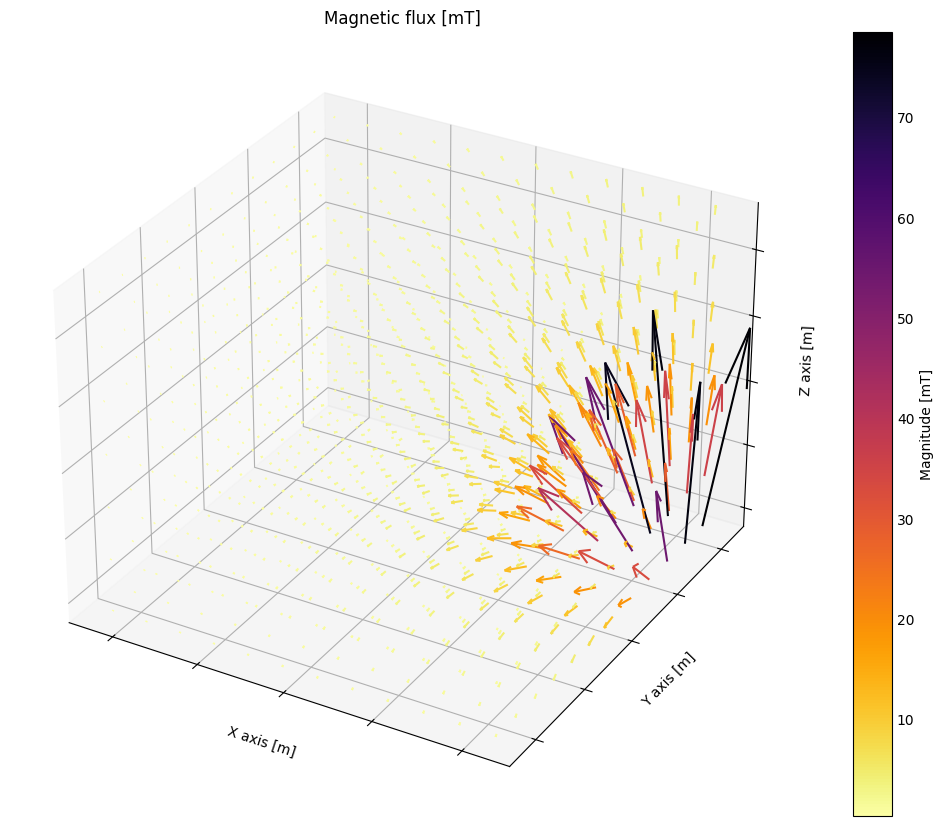

In [384]:
Quiver_plot(grid_pts,field)

In [289]:
def isloate_measurement(measured_data, input_current, coil_no):
    measured_field = {}
    #isolating the set current values
    for i in input_current:
        data= measured_data[measured_data[f'cmdCoilCurrent_{coil_no}(A)'] == i]
        U = data[['sensor_1_X [mT]','sensor_2_X [mT]','sensor_3_X [mT]','sensor_4_X [mT]',
                    'sensor_5_X [mT]','sensor_6_X [mT]','sensor_7_X [mT]','sensor_8_X [mT]',
                    'sensor_9_X [mT]','sensor_10_X [mT]','sensor_11_X [mT]','sensor_12_X [mT]',
                    'sensor_13_X [mT]','sensor_14_X [mT]','sensor_15_X [mT]','sensor_16_X [mT]']].values.reshape(-1, 1)

        V = data[['sensor_1_Y [mT]','sensor_2_Y [mT]','sensor_3_Y [mT]','sensor_4_Y [mT]',
                        'sensor_5_Y [mT]','sensor_6_Y [mT]','sensor_7_Y [mT]','sensor_8_Y [mT]',
                        'sensor_9_Y [mT]','sensor_10_Y [mT]','sensor_11_Y [mT]','sensor_12_Y [mT]',
                        'sensor_13_Y [mT]','sensor_14_Y [mT]','sensor_15_Y [mT]','sensor_16_Y [mT]']].values.reshape(-1, 1)
        
        W = data[['sensor_1_Z [mT]','sensor_2_Z [mT]','sensor_3_Z [mT]','sensor_4_Z [mT]',
                    'sensor_5_Z [mT]','sensor_6_Z [mT]','sensor_7_Z [mT]','sensor_8_Z [mT]',
                    'sensor_9_Z [mT]','sensor_10_Z [mT]','sensor_11_Z [mT]','sensor_12_Z [mT]',
                    'sensor_13_Z [mT]','sensor_14_Z [mT]','sensor_15_Z [mT]','sensor_16_Z [mT]']].values.reshape(-1, 1)
        
        field = np.hstack((U,V,W))
        field = np.vstack(field)
        
        
        x = data[['Sensor_1_dir_x','Sensor_2_dir_x','Sensor_3_dir_x','Sensor_4_dir_x',
                'Sensor_5_dir_x','Sensor_6_dir_x','Sensor_7_dir_x','Sensor_8_dir_x',
                'Sensor_9_dir_x','Sensor_10_dir_x','Sensor_11_dir_x','Sensor_12_dir_x',
                'Sensor_13_dir_x','Sensor_14_dir_x','Sensor_15_dir_x','Sensor_16_dir_x']].values.reshape(-1, 1)
        
        y = data[['Sensor_1_dir_y','Sensor_2_dir_y','Sensor_3_dir_y','Sensor_4_dir_y',
                    'Sensor_5_dir_y','Sensor_6_dir_y','Sensor_7_dir_y','Sensor_8_dir_y',
                    'Sensor_9_dir_y','Sensor_10_dir_y','Sensor_11_dir_y','Sensor_12_dir_y',
                    'Sensor_13_dir_y','Sensor_14_dir_y','Sensor_15_dir_y','Sensor_16_dir_y']].values.reshape(-1, 1)
        
        z = data[['Sensor_1_dir_z','Sensor_2_dir_z','Sensor_3_dir_z','Sensor_4_dir_z',
                    'Sensor_5_dir_z','Sensor_6_dir_z','Sensor_7_dir_z','Sensor_8_dir_z',
                    'Sensor_9_dir_z','Sensor_10_dir_z','Sensor_11_dir_z','Sensor_12_dir_z',
                    'Sensor_13_dir_z','Sensor_14_dir_z','Sensor_15_dir_z','Sensor_16_dir_z']].values.reshape(-1, 1)
        
        grid_pts = np.hstack((x,y,z))
        grid_pts = np.vstack((grid_pts))
               
        measured_field[i] = [grid_pts, field]

    
    return measured_field

In [148]:
def Calc_error(U_measured,V_measured,W_measured, U1, V1, W1):
    U_error = U_measured - U1
    V_error = V_measured - V1
    W_error = W_measured - W1
    
    # Orientation error

    M_measured = np.sqrt(U_measured**2 + V_measured**2 + W_measured**2)   # magnitude 
    M1 = np.sqrt(U1**2 + V1**2 + W1**2) # magnitude

    H_measured = np.sqrt(U_measured**2 + V_measured**2)   # magnitude in the horizontal plane
    H1 = np.sqrt(U1**2 + V1**2)  # magnitude in the horizontal plane

    with np.errstate(divide='ignore', invalid='ignore'):
        phi_measured = np.arcsin(np.nan_to_num(W_measured/M_measured, nan = 0, posinf=0, neginf=0))  # orientation of the magnetic field relative to the horizontal plane
        phi1 = np.arcsin(np.nan_to_num(W1/M1,nan = 0, posinf=0, neginf=0))

        theta_measured = np.arcsin(np.nan_to_num(V_measured/H_measured, nan = 0, posinf=0, neginf=0)) # orientation of the magnetic field relative to the x-axis
        theta1 = np.arcsin(np.nan_to_num(V1/H1,nan = 0, posinf=0, neginf=0))

    phi_error = phi_measured - phi1
    theta_error = theta_measured - theta1
    
    
    # mean absolute error calculation
    U_abs_error = np.mean(np.abs(U_error))
    V_abs_error = np.mean(np.abs(V_error))
    W_abs_error = np.mean(np.abs(W_error))
    M_abs_error = np.mean(np.abs(M1-M_measured))

    # print('U_MAE: ', U_abs_error)
    # print('V_MAE: ', V_abs_error)
    # print('W_MAE: ', W_abs_error)
    # print('M_MAE: ', M_abs_error)
    
    
    # Mean Absolute Percentage Error calculation
    with np.errstate(divide='ignore', invalid='ignore'): # to ignor the error prompt when dividing by zero
        U_MAPE = np.mean(np.abs(np.nan_to_num(U_error/U_measured, nan = 0, posinf=0, neginf=0))*100)
        V_MAPE = np.mean(np.abs(np.nan_to_num(V_error/V_measured, nan = 0, posinf=0, neginf=0))*100)
        W_MAPE = np.mean(np.abs(np.nan_to_num(W_error/W_measured, nan = 0, posinf=0, neginf=0))*100)
        M_MAPE = np.mean(np.abs(np.nan_to_num((M1-M_measured)/M_measured, nan = 0, posinf=0, neginf=0))*100)

    # print('U_MAPE: ', U_MAPE)
    # print('V_MAPE: ', V_MAPE)
    # print('W_MAPE: ', W_MAPE)
    # print('M_MAPE: ', M_MAPE)
    
    
    # mean absolute error for the orientaion
    phi_abs_error = np.mean(np.abs(phi_error))
    theta_abs_error = np.mean(np.abs(theta_error))

    # print('phi_MAE: ', phi_abs_error, "(", np.degrees(phi_abs_error),")")
    # print('theta_MAE: ', theta_abs_error, "(", np.degrees(theta_abs_error),")")
    
    return [U_abs_error, V_abs_error, W_abs_error, M_abs_error, phi_abs_error, theta_abs_error, U_MAPE, V_MAPE, W_MAPE, M_MAPE]
    

In [366]:
def Plot(dic, coil_no): # scatter plot dictionary
    
    # Extract keys and values from the dictionary
    keys = list(dic.keys())
    values = list(dic.values())

    # Number of columns to plot
    num_columns = len(values[0])  # Assume all lists have the same length
    
    labels = ['X', 'Y', 'Z', 'Magnitude','ϕ (pitch angle)', 'θ (yaw angle)' ]
    colors = ['r','g','b','k','cyan', 'darkviolet' ]
    

    
    
    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(8,5))
    
    # Define a list of colors for each scatter plot
    

    # Plot each column
    for i in range(4):
        column_values = [value[i] for value in values]  # Extract the i-th column from each list
        ax1.plot(keys, column_values, label=labels[i], color=colors[i])
        
    # Create secondary y-axis
    ax2 = ax1.twinx()
    
    # Plot the last two columns on the secondary y-axis
    for i in range(4, 6):
        column_values = [value[i] for value in values]
        ax2.plot(keys, np.degrees(column_values), label=labels[i], linestyle='--', color=colors[i])
        
    # Set custom limits for the primary y-axis
    #ax2.set_ylim(0, 5)  # Example range for Value1

    # Add labels and title
    ax1.set_xlabel('Command current values [Ampere]')
    ax1.set_ylabel('Mean absolute error [mT]')
    ax2.set_ylabel('Mean absolute error [degrees]')
    plt.title(f'Prediction error (MAE) of the dipole model for coil {coil_no}')

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)
    
    

    # Show the plot
    plt.show()
    
    
def PercentageErrorPlot(dic, coil_no): # scatter plot dictionary
    
    # Extract keys and values from the dictionary
    keys = list(dic.keys())
    values = list(dic.values())

    # Number of columns to plot
    num_columns = len(values[0])  # Assume all lists have the same length
    
    labels = ['X', 'Y', 'Z', 'Magnitude','ϕ (pitch angle)', 'θ (yaw angle)' ]
    colors = ['r','g','b','k','cyan', 'darkviolet' ]
    

    
    
    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(8,5))
    
    # Define a list of colors for each scatter plot
    

    # Plot each column
    for i in range(6,10):
        column_values = [value[i] for value in values]  # Extract the i-th column from each list
        ax1.plot(keys, column_values, label=labels[i-6], color=colors[i-6])
        
    # Create secondary y-axis
    ax2 = ax1.twinx()
    
    # Plot the last two columns on the secondary y-axis
    for i in range(4, 6):
        column_values = [value[i] for value in values]
        ax2.plot(keys, np.degrees(column_values), label=labels[i], linestyle='--', color=colors[i])
        
    # Set custom limits for the primary y-axis
    #ax2.set_ylim(0, 5)  # Example range for Value1

    # Add labels and title
    ax1.set_xlabel('Command current values [Ampere]')
    ax1.set_ylabel('Mean absolute percentage error [%]')
    ax2.set_ylabel('Mean absolute error [degrees]')
    plt.title(f'Prediction error (MAPE) of the dipole model for coil {coil_no}')

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)
    
    

    # Show the plot
    plt.show()



        

In [369]:
def eval_error(coil_data, coil_no):
    cmdCurrent = [i for i in range (-13,15,2)]
    
    measured_field = isloate_measurement(coil_data, cmdCurrent,coil_no) # measured current

    
    
    error = {}
    momement = {}
    for i in cmdCurrent:
        
        measured_data = measured_field[i]
        grid_pts = measured_data[0]  # using the grid pt measurement from the measured values
        
        
        U_measured = measured_data[1][:,0]
        V_measured = measured_data[1][:,1]
        W_measured = measured_data[1][:,2]
        
        grid_pts, field, m = dipole_predict(grid_pts,i,coil_no)
        
        
        U1 = field[:,0]
        V1 = field[:,1]
        W1 = field[:,2]
    
    
        error[i] = Calc_error(U_measured,V_measured,W_measured, U1, V1, W1)
        momement[i] = m
         
        
    Plot(error, coil_no)
    PercentageErrorPlot(error, coil_no)

        

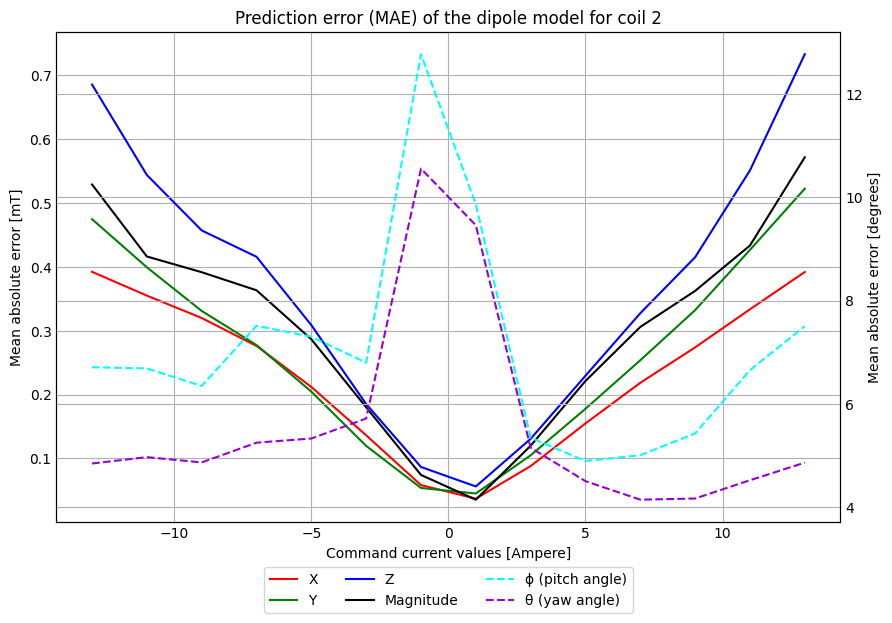

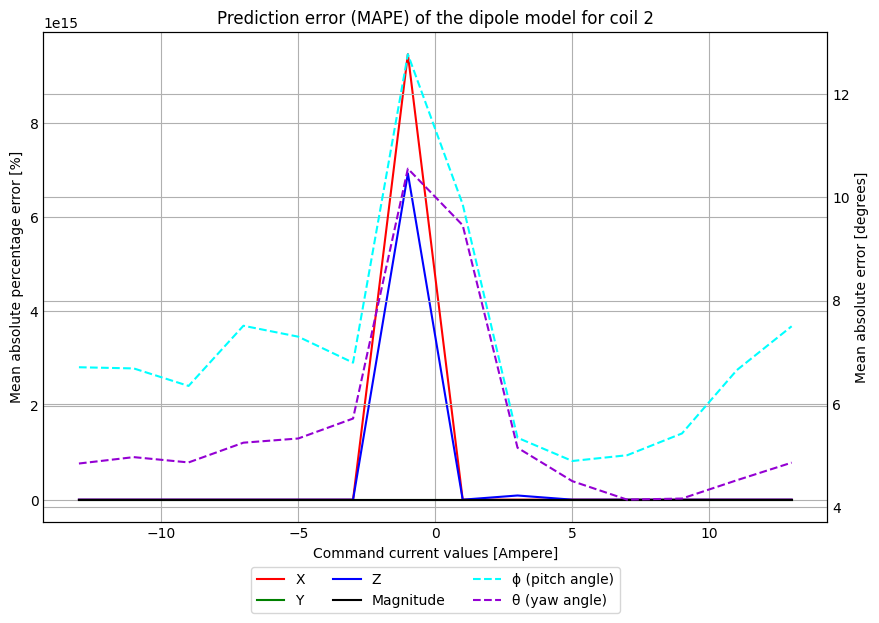

In [370]:
C2 = pd.read_csv('Processed_data/coil2_data.csv', parse_dates = True, index_col=0)  #  Coil data
eval_error(C2,2)

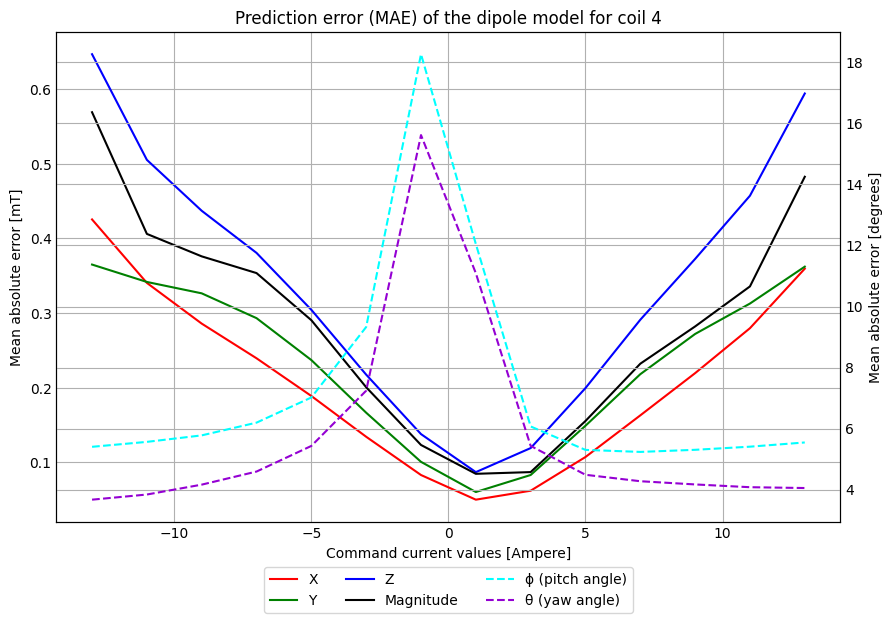

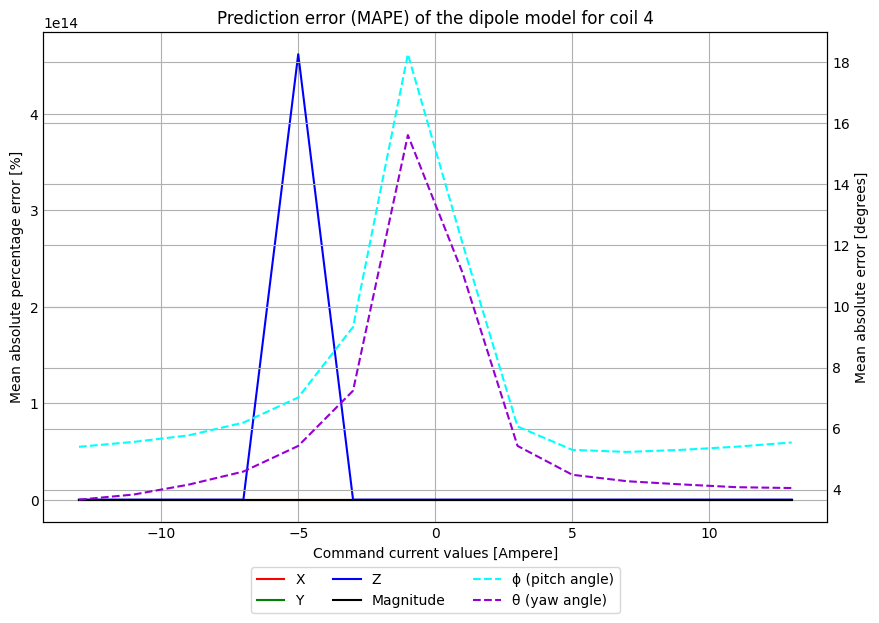

In [350]:
C4 = pd.read_csv('Processed_data/coil4_data.csv', parse_dates = True, index_col=0)  #  Coil data
eval_error(C4,4)

In [239]:
def dipole_predict_2(grid_pts, coilAmp): # a single dipole at the surface
    
    numCoilLoops = 1630
    wireCrossSectionArea = 3.31e-6
    
    momentMagnitude = electromagneticCoilMomentMagnitude(numCoilLoops, wireCrossSectionArea, coilAmp)

    htm_originToDipoleCenter = np.identity((4))
    htm_originToMeasurementPoint = np.identity((4))

    htm_originToDipoleCenter[1,3] = -0.132  # coil#2

   
    field = np.zeros(grid_pts.shape)
     
    field_predicted = []

    for r in grid_pts:
        htm_originToMeasurementPoint[0:3, 3] = r
        field_predicted.append(dipoleMagneticFluxDensity_htm(momentMagnitude, htm_originToDipoleCenter, htm_originToMeasurementPoint))
        
    field_predicted = np.array(field_predicted)*1000
    
    field =+ field_predicted
        
        
    return grid_pts, field


In [240]:
def eval_error_2(coil_data):
    cmdCurrent = [i for i in range (-15,17,2)]
    
    measured_field = isloate_measurement(coil_data, cmdCurrent) # measured current

    
    predicted_field = {}
    error = {}
    for i in cmdCurrent:
        
        measured_data = measured_field[i]
        grid_pts = measured_data[0]  # using the grid pt measurement from the measured values
        
        
        U_measured = measured_data[1][:,0]
        V_measured = measured_data[1][:,1]
        W_measured = measured_data[1][:,2]
        
        grid_pts, field = dipole_predict_2(grid_pts,i)
        predicted_field[i] = zip(grid_pts, field)
        
        U1 = field[:,0]
        V1 = field[:,1]
        W1 = field[:,2]
    
    
        error[i] = Calc_error(U_measured,V_measured,W_measured, U1, V1, W1)
         
        
    scatterPlot(error)

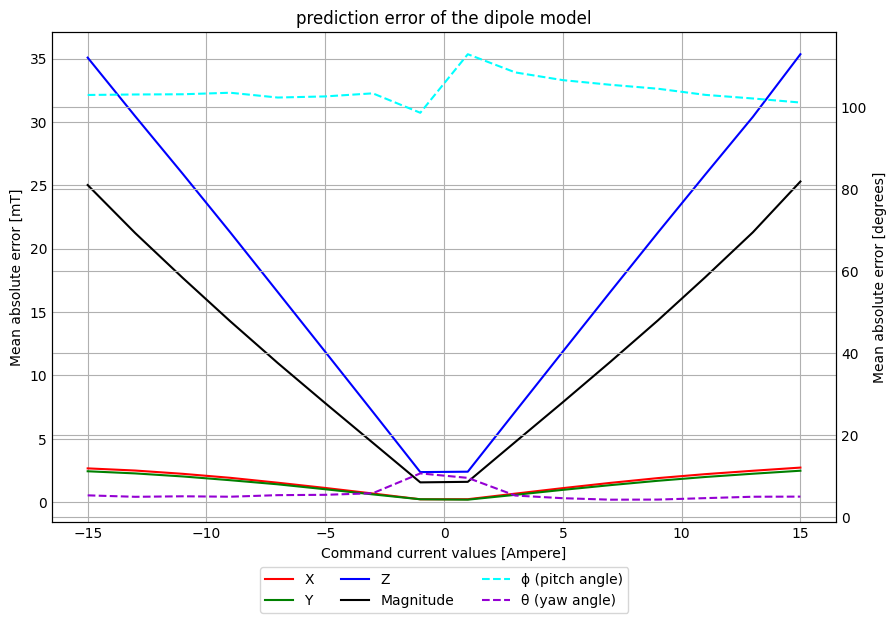

In [272]:
eval_error_2(C2)

In [242]:
def dipole_predict_3(grid_pts, coilAmp): # a single dipole at the scentre of the coil
    
    numCoilLoops = 1630
    wireCrossSectionArea = 3.31e-6
    
    momentMagnitude = electromagneticCoilMomentMagnitude(numCoilLoops, wireCrossSectionArea, coilAmp)

    htm_originToDipoleCenter = np.identity((4))
    htm_originToMeasurementPoint = np.identity((4))

    htm_originToDipoleCenter[1,3] = -0.132  # coil#2

    htm_originToDipoleCenter[2,3] = -0.018 
    
    field = np.zeros(grid_pts.shape)
     
    field_predicted = []

    for r in grid_pts:
        htm_originToMeasurementPoint[0:3, 3] = r
        field_predicted.append(dipoleMagneticFluxDensity_htm(momentMagnitude, htm_originToDipoleCenter, htm_originToMeasurementPoint))
        
    field_predicted = np.array(field_predicted)*1000
    
    field =+ field_predicted
        
        
    return grid_pts, field

In [243]:
def eval_error_3(coil_data):
    cmdCurrent = [i for i in range (-15,17,2)]
    
    measured_field = isloate_measurement(coil_data, cmdCurrent) # measured current

    
    predicted_field = {}
    error = {}
    for i in cmdCurrent:
        
        measured_data = measured_field[i]
        grid_pts = measured_data[0]  # using the grid pt measurement from the measured values
        
        
        U_measured = measured_data[1][:,0]
        V_measured = measured_data[1][:,1]
        W_measured = measured_data[1][:,2]
        
        grid_pts, field = dipole_predict_3(grid_pts,i)
        predicted_field[i] = zip(grid_pts, field)
        
        U1 = field[:,0]
        V1 = field[:,1]
        W1 = field[:,2]
    
    
        error[i] = Calc_error(U_measured,V_measured,W_measured, U1, V1, W1)
         
        
    scatterPlot(error)

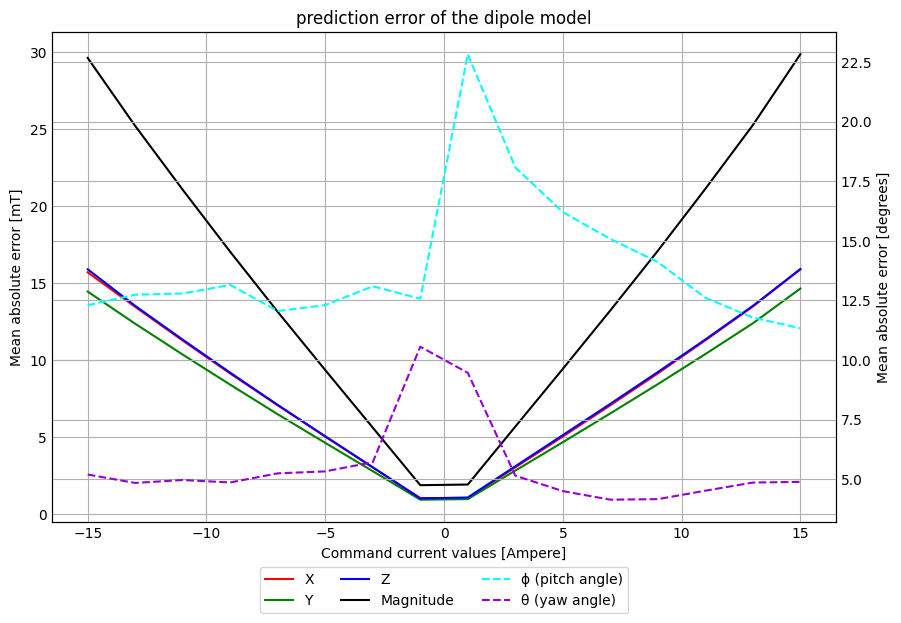

In [244]:
eval_error_3(C2)

Dipole model prediction vs measured data under superpositioning (complex magnetic field)

In [393]:
df1_clean = pd.read_csv('superposition_test/test1_measured.csv', parse_dates = True, index_col=0)  #  table data
df2_clean = pd.read_csv('superposition_test/test2_measured.csv', parse_dates = True, index_col=0)  #  table data
df3_clean = pd.read_csv('superposition_test/test3_measured.csv', parse_dates = True, index_col=0)  #  table data

In [401]:
def superimpose(data, cmdCurrent):
        x = data[['Sensor_1_dir_x','Sensor_2_dir_x','Sensor_3_dir_x','Sensor_4_dir_x',
                'Sensor_5_dir_x','Sensor_6_dir_x','Sensor_7_dir_x','Sensor_8_dir_x',
                'Sensor_9_dir_x','Sensor_10_dir_x','Sensor_11_dir_x','Sensor_12_dir_x',
                'Sensor_13_dir_x','Sensor_14_dir_x','Sensor_15_dir_x','Sensor_16_dir_x']].values.reshape(-1, 1)

        y = data[['Sensor_1_dir_y','Sensor_2_dir_y','Sensor_3_dir_y','Sensor_4_dir_y',
                'Sensor_5_dir_y','Sensor_6_dir_y','Sensor_7_dir_y','Sensor_8_dir_y',
                'Sensor_9_dir_y','Sensor_10_dir_y','Sensor_11_dir_y','Sensor_12_dir_y',
                'Sensor_13_dir_y','Sensor_14_dir_y','Sensor_15_dir_y','Sensor_16_dir_y']].values.reshape(-1, 1)

        z = data[['Sensor_1_dir_z','Sensor_2_dir_z','Sensor_3_dir_z','Sensor_4_dir_z',
                'Sensor_5_dir_z','Sensor_6_dir_z','Sensor_7_dir_z','Sensor_8_dir_z',
                'Sensor_9_dir_z','Sensor_10_dir_z','Sensor_11_dir_z','Sensor_12_dir_z',
                'Sensor_13_dir_z','Sensor_14_dir_z','Sensor_15_dir_z','Sensor_16_dir_z']].values.reshape(-1, 1)

        grid_pts = np.hstack((x,y,z))
        grid_pts = np.vstack((grid_pts))

        

        cx_field = np.zeros(grid_pts.shape)

        for index, current in enumerate(cmdCurrent):
                _ , field, m = dipole_predict(grid_pts,current,index+1)
                cx_field += field
                
        Quiver_plot(grid_pts,cx_field)
        
        U1 = cx_field[:,0]
        V1 = cx_field[:,1]
        W1 = cx_field[:,2]
        
        
        U_measured = data[['sensor_1_X [mT]','sensor_2_X [mT]','sensor_3_X [mT]','sensor_4_X [mT]',
                    'sensor_5_X [mT]','sensor_6_X [mT]','sensor_7_X [mT]','sensor_8_X [mT]',
                    'sensor_9_X [mT]','sensor_10_X [mT]','sensor_11_X [mT]','sensor_12_X [mT]',
                    'sensor_13_X [mT]','sensor_14_X [mT]','sensor_15_X [mT]','sensor_16_X [mT]']].values.reshape(-1, 1)

        V_measured = data[['sensor_1_Y [mT]','sensor_2_Y [mT]','sensor_3_Y [mT]','sensor_4_Y [mT]',
                        'sensor_5_Y [mT]','sensor_6_Y [mT]','sensor_7_Y [mT]','sensor_8_Y [mT]',
                        'sensor_9_Y [mT]','sensor_10_Y [mT]','sensor_11_Y [mT]','sensor_12_Y [mT]',
                        'sensor_13_Y [mT]','sensor_14_Y [mT]','sensor_15_Y [mT]','sensor_16_Y [mT]',]].values.reshape(-1, 1)


        W_measured = data[['sensor_1_Z [mT]','sensor_2_Z [mT]','sensor_3_Z [mT]','sensor_4_Z [mT]',
                        'sensor_5_Z [mT]','sensor_6_Z [mT]','sensor_7_Z [mT]','sensor_8_Z [mT]',
                        'sensor_9_Z [mT]','sensor_10_Z [mT]','sensor_11_Z [mT]','sensor_12_Z [mT]',
                        'sensor_13_Z [mT]','sensor_14_Z [mT]','sensor_15_Z [mT]','sensor_16_Z [mT]',]].values.reshape(-1, 1)
        
        
        U_error = U_measured - U1
        V_error = V_measured - V1
        W_error = W_measured - W1
        
        # Orientation error

        M_measured = np.sqrt(U_measured**2 + V_measured**2 + W_measured**2)   # magnitude 
        M1 = np.sqrt(U1**2 + V1**2 + W1**2) # magnitude

        H_measured = np.sqrt(U_measured**2 + V_measured**2)   # magnitude in the horizontal plane
        H1 = np.sqrt(U1**2 + V1**2)  # magnitude in the horizontal plane

        with np.errstate(divide='ignore', invalid='ignore'):
                phi_measured = np.arcsin(np.nan_to_num(W_measured/M_measured, nan = 0, posinf=0, neginf=0))  # orientation of the magnetic field relative to the horizontal plane
                phi1 = np.arcsin(np.nan_to_num(W1/M1,nan = 0, posinf=0, neginf=0))

                theta_measured = np.arcsin(np.nan_to_num(V_measured/H_measured, nan = 0, posinf=0, neginf=0)) # orientation of the magnetic field relative to the x-axis
                theta1 = np.arcsin(np.nan_to_num(V1/H1,nan = 0, posinf=0, neginf=0))

        phi_error = phi_measured - phi1
        theta_error = theta_measured - theta1
        
        
        # mean absolute error calculation
        U_abs_error = np.mean(np.abs(U_error))
        V_abs_error = np.mean(np.abs(V_error))
        W_abs_error = np.mean(np.abs(W_error))
        M_abs_error = np.mean(np.abs(M1-M_measured))

        print('U_MAE: ', U_abs_error)
        print('V_MAE: ', V_abs_error)
        print('W_MAE: ', W_abs_error)
        print('M_MAE: ', M_abs_error)
        
        
        # Mean Absolute Percentage Error calculation
        with np.errstate(divide='ignore', invalid='ignore'): # to ignor the error prompt when dividing by zero
                U_MAPE = np.mean(np.abs(np.nan_to_num(U_error/U_measured, nan = 0, posinf=0, neginf=0))*100)
                V_MAPE = np.mean(np.abs(np.nan_to_num(V_error/V_measured, nan = 0, posinf=0, neginf=0))*100)
                W_MAPE = np.mean(np.abs(np.nan_to_num(W_error/W_measured, nan = 0, posinf=0, neginf=0))*100)
                M_MAPE = np.mean(np.abs(np.nan_to_num((M1-M_measured)/M_measured, nan = 0, posinf=0, neginf=0))*100)

        print('U_MAPE: ', U_MAPE)
        print('V_MAPE: ', V_MAPE)
        print('W_MAPE: ', W_MAPE)
        print('M_MAPE: ', M_MAPE)
        
        
        # mean absolute error for the orientaion
        phi_abs_error = np.mean(np.abs(phi_error))
        theta_abs_error = np.mean(np.abs(theta_error))

        print('phi_MAE: ', phi_abs_error, "(", np.degrees(phi_abs_error),")")
        print('theta_MAE: ', theta_abs_error, "(", np.degrees(theta_abs_error),")")

30.80855979408638


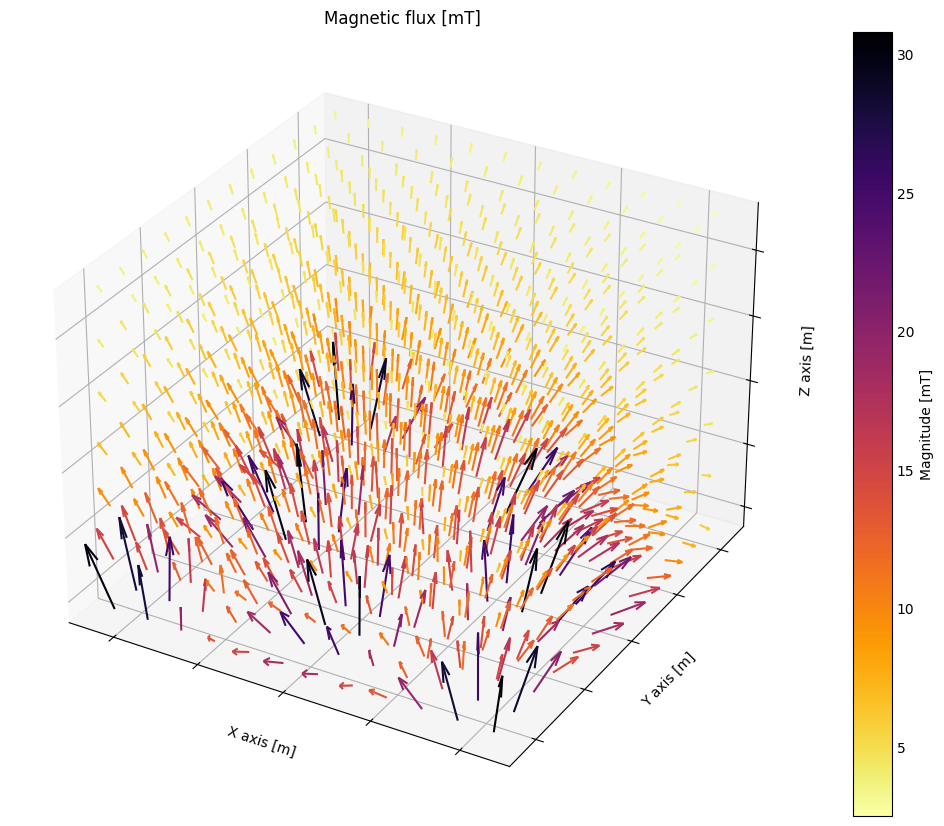

U_MAE:  4.047334731923092
V_MAE:  3.9714779726416802
W_MAE:  4.764169213800304
M_MAE:  5.091759593661361
U_MAPE:  758.0082376510059
V_MAPE:  1399.9243080790914
W_MAPE:  137.71928333399768
M_MAPE:  72.76871519216195
phi_MAE:  0.36016395133246426 ( 20.635874344105385 )
theta_MAE:  1.0162147977155866 ( 58.224818987843804 )


In [402]:
cmdCurrent = [5,5,5,5,5,0,5,5]
superimpose(df1_clean,cmdCurrent)

62.05804029253097


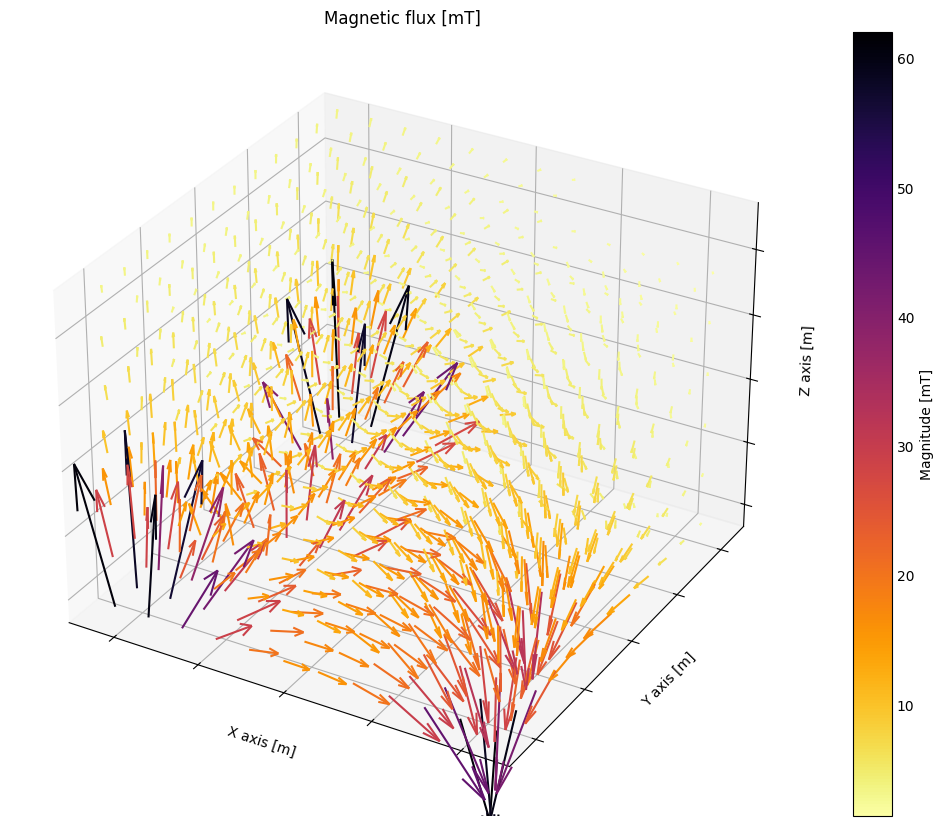

U_MAE:  6.398194201226688
V_MAE:  3.0693192012944133
W_MAE:  10.42100259344165
M_MAE:  8.609033042144674
U_MAPE:  346.62772047248586
V_MAPE:  680.8321139086844
W_MAPE:  549.4976390135064
M_MAPE:  102.70231378921503
phi_MAE:  0.9510651462383317 ( 54.49201892144885 )
theta_MAE:  0.5695366380696022 ( 32.6320456394581 )


In [398]:
cmdCurrent = [10,0,-10,-5,5,0,0,10]
superimpose(df2_clean, cmdCurrent)

61.33172223311889


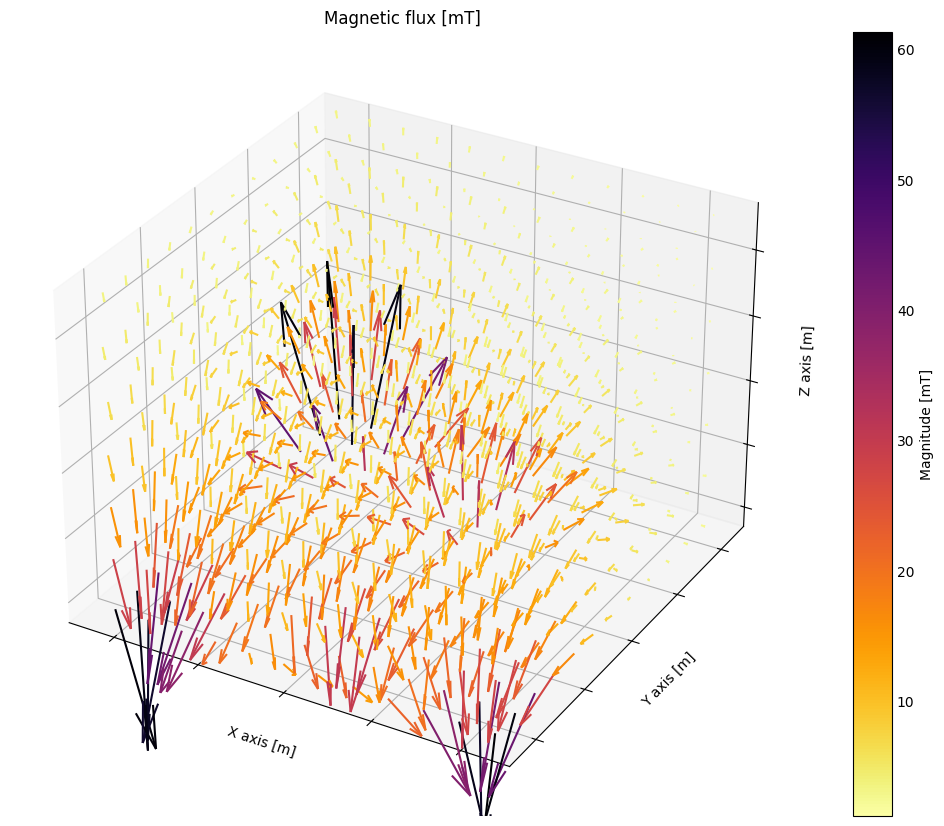

U_MAE:  2.9363499766910226
V_MAE:  6.554134448772732
W_MAE:  10.32869880729935
M_MAE:  8.698312230829323
U_MAPE:  597.438010462764
V_MAPE:  405.2799726727459
W_MAPE:  688.7488627746127
M_MAPE:  106.87272486894803
phi_MAE:  0.9469886344902323 ( 54.258452003147255 )
theta_MAE:  0.6571426872984829 ( 37.65150252008828 )


In [400]:
cmdCurrent = [-10,-5,-10,0,0,0,5,10]
superimpose(df3_clean,cmdCurrent)